In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager
from matplotlib.colors import LinearSegmentedColormap
import math
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import matplotlib.patches as patches
import warnings
from pandas.core.common import SettingWithCopyWarning
from IPython.display import display, Math, Latex

#mdf as the master dataframe
mdf = pd.read_csv('Footballdata/A/A.csv', encoding='latin-1')

#Adjust to pitch size
mdf['x'] = mdf['x']*1.2
mdf['y'] = mdf['y']*.8
mdf['endX'] = mdf['endX']*1.2
mdf['endY'] = mdf['endY']*.8

In [2]:
#Remove warning
pd.options.mode.chained_assignment = None

#Deep Completions Passes
df = mdf

#remove unwated records
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]
df = df.loc[~(df['type/displayName'] == 'FormationSet')]
df = df.loc[~(df['type/displayName'] == 'Start')]
df = df.loc[~(df['type/displayName'] == 'End')]

#remove the records of a failed aerial
df = df.loc[~((df['type/displayName'] == 'Aerial') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#Finding previous event to filter out setpieces
df['prevevent'] = df['type/displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]

#distance of passes
df['initialDistancefromgoal'] = np.sqrt(((120 - df['x'])**2) + ((40 - df['y'])**2))
df['finalDistancefromgoal'] = np.sqrt(((120 - df['endX'])**2) + ((40 - df['endY'])**2))

#Calculate deep completions from passes
df['deepCompletion'] = np.where(((df['finalDistancefromgoal'] <= (21.87)) & 
                                 (df['initialDistancefromgoal'] >= (21.87))), 'True', 'False')

deepcompletionpass = df.loc[(df['x']< 119) & 
                          (((df['deepCompletion']=='True') & 
                            (df['type/displayName']=='Pass')&
                            (df['outcomeType/displayName']=='Successful')))]

deepcompletionpass_list = deepcompletionpass.groupby(['playername','teamId']).size().reset_index().rename(columns={0:'Passes'}).sort_values('Passes', ascending = False).reset_index()
del deepcompletionpass_list['index']
deepcompletionpass_list.index += 1
deepcompletionpass_list.head(5)

,playername,teamId,Passes
1,Gabriel Martinelli,Arsenal,17
2,Bukayo Saka,Arsenal,14
3,Martin Ødegaard,Arsenal,13
4,Ben White,Arsenal,8
5,Gabriel Jesus,Arsenal,8


In [3]:
#Remove warning
pd.options.mode.chained_assignment = None

#Deep Completion Carries df
df1 = mdf

#remove substitution events,challenges & formation change
df1 = df1.loc[~(df1['type/displayName'] == 'SubstitutionOff')]
df1 = df1.loc[~(df1['type/displayName'] == 'SubstitutionOn')]
df1 = df1.loc[~(df1['type/displayName'] == 'FormationChange')]
df1 = df1.loc[~(df1['type/displayName'] == 'Challenge')]
df1 = df1.loc[~(df1['type/displayName'] == 'FormationSet')]
df1 = df1.loc[~(df1['type/displayName'] == 'Start')]
df1 = df1.loc[~(df1['type/displayName'] == 'End')]
df1 = df1.loc[~(df1['type/displayName'] == 'Aerial')]
df1 = df1.loc[~(df1['type/displayName'] == 'Tackle')]

#remove the records of a failed foul, they should be ignored as their challenges are failed and the shot continues
df1 = df1.loc[~((df1['type/displayName'] == 'Foul') & (df1['outcomeType/displayName'] == 'Unsuccessful'))]

#remove the records of a corners awarded, they should be ignored as their challenges are failed and the shot continues
df1 = df1.loc[~((df1['type/displayName'] == 'CornerAwarded') & (df1['outcomeType/displayName'] == 'Unsuccessful'))]

#Filter for ball touches and whether it is a ball recovery
actions = df1.loc[(df1['isTouch'] == True)
                 |(df1['type/displayName'] == 'BallRecovery')]

#Taking the variables that are needed
actions = actions[['expandedMinute','teamId','type/displayName','outcomeType/displayName','playername','x','y','endX','endY']]

#finding the Recipient of the action/pass made
actions['Recipient'] = actions['playername'].shift(-1)

#finding the next event that occured along with the x & y positions
actions['nextEvent'] = actions['type/displayName'].shift(-1)
actions['x_next'] = actions['x'].shift(-1)
actions['y_next'] = actions['y'].shift(-1)
actions['outcomeType_next'] = actions['outcomeType/displayName'].shift(-1)

#find if the next event is by the same team
actions['teamId_next'] = actions['teamId'].shift(-1)

actions = actions.loc[ (actions['nextEvent'] == 'Pass')
                      |(actions['nextEvent'] == 'TakeOn')
                      |(actions['nextEvent'] == 'Dispossessed')
                      |(actions['nextEvent'] == 'BallRecovery')
                      |(actions['nextEvent'] == 'MissedShots')
                      |(actions['nextEvent'] == 'ShotOnPost')
                      |(actions['nextEvent'] == 'Goal')
                      |(actions['nextEvent'] == 'GoodSkill')
                      |(actions['nextEvent'] == 'SavedShot')
                      |(actions['nextEvent'] == 'BallTouch')
                      |((actions['nextEvent'] == 'Foul') & (actions['outcomeType_next'] == 'Successful'))
                      |((actions['nextEvent'] == 'CornerAwarded') & (actions['outcomeType_next'] == 'Successful'))]

#to calculate the distance between the carried distance, using Euclidean formula
#needs to be more than or equals to a certain value
min_dribble_length = 4
far_enough = (actions['x_next']-actions['endX'])**2 + (actions['y_next'] -actions['endY'])**2 >= min_dribble_length**2

#Check if next team is the same team
same_team = actions['teamId'] == actions['teamId_next']

#filter to find the carries
carries = actions[(far_enough) & (same_team)]

#New variables to check the distance between the beginning location and end location to the goal
carries['beginning'] = np.sqrt(np.square(120-carries['endX'])+np.square(40-carries['endY']))
carries['end'] = np.sqrt(np.square(120-carries['x_next'])+np.square(40-carries['y_next']))

carries['deepCompletioncarries'] = np.where((carries['end'] <= (21.87)) & (carries['beginning'] >= (21.87)), 'True', 'False')
deepcompletioncarries = carries.loc[carries['deepCompletioncarries'] == 'True']

deepcompletioncarries_list = deepcompletioncarries.groupby(['Recipient','teamId']).size().reset_index().rename(columns={0:'Carries','Recipient':'playername'}).sort_values('Carries', ascending = False).reset_index()
del deepcompletioncarries_list['index']
deepcompletioncarries_list.index += 1
deepcompletioncarries_list.head(5)

,playername,teamId,Carries
1,Gabriel Martinelli,Arsenal,9
2,Bukayo Saka,Arsenal,7
3,Gabriel Jesus,Arsenal,6
4,Eddie Nketiah,Arsenal,3
5,Wilfried Zaha,Crystal Palace,2


In [4]:
#List for two of them combined, must have values in each list
Deep_Completions_List = pd.merge(deepcompletionpass_list, deepcompletioncarries_list, on="playername")
Deep_Completions_List = Deep_Completions_List.drop(['teamId_y'], axis = 1)
Deep_Completions_List.rename(columns = {'teamId_x':'Team', 'playername':'Player'},inplace = True)
Deep_Completions_List = Deep_Completions_List.sort_values('Passes', ascending= False).reset_index(drop = True)
Deep_Completions_List.index += 1
Deep_Completions_List.head(10)

,Player,Team,Passes,Carries
1,Gabriel Martinelli,Arsenal,17,9
2,Bukayo Saka,Arsenal,14,7
3,Martin Ødegaard,Arsenal,13,2
4,Gabriel Jesus,Arsenal,8,6
5,Wilfried Zaha,Crystal Palace,3,2
6,Jordan Zemura,Bournemouth,2,1
7,James Maddison,Leicester City,2,1
8,Emile Smith Rowe,Arsenal,2,1
9,Eddie Nketiah,Arsenal,2,3
10,Rico Henry,Brentford,1,1


In [5]:
options = df["playername"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Eberechi Eze', 'Joachim Andersen', 'Ma…

In [6]:
player = playerlist.value

npass = len(deepcompletionpass[(deepcompletionpass['playername'] == player)].index)
ncarry = len(deepcompletioncarries[(deepcompletioncarries['Recipient'] == player)].index)

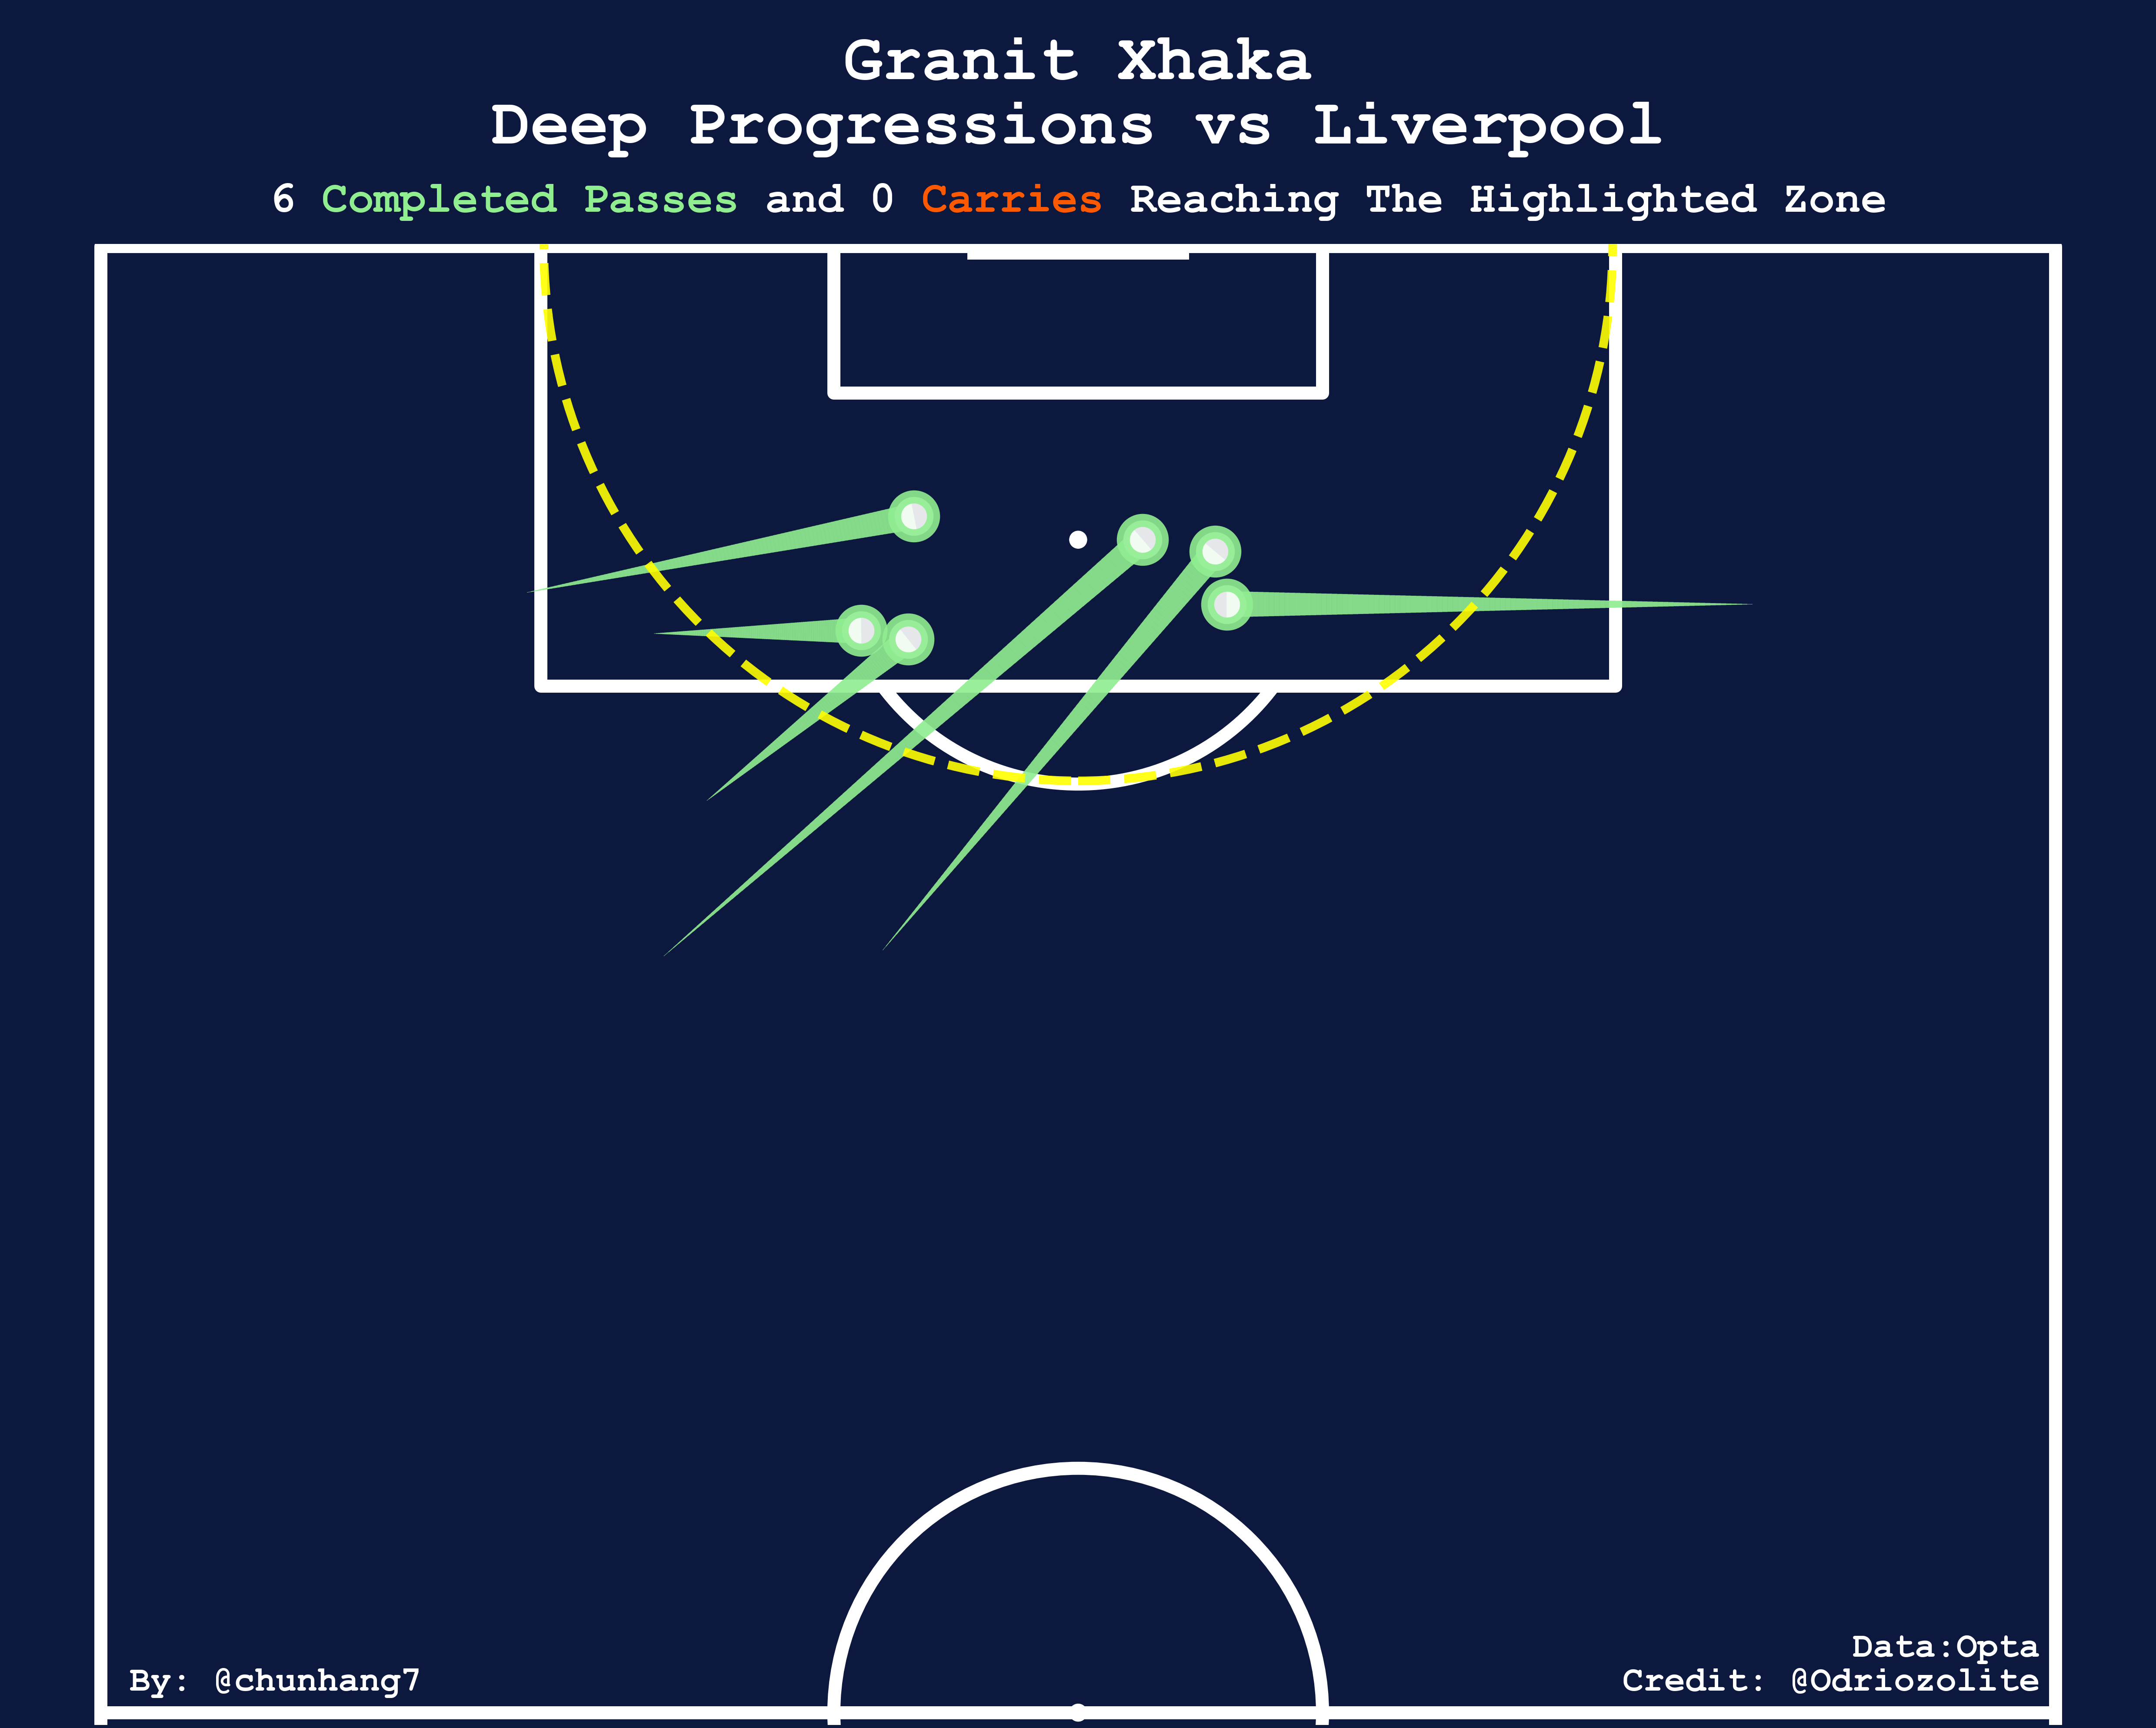

In [7]:
#Plotting the pitch
pitch = VerticalPitch(pitch_type='statsbomb', pad_top=0.1, pad_bottom=0.5,
                  pitch_color="#0d183f", line_color="white",half = True, line_zorder=1, linewidth=30, spot_scale=0.003)

fig, ax = pitch.grid(nrows=1, ncols=1, figheight=55,
                     endnote_height=0.0, endnote_space=0, axis=False,
                     title_height=0.13, grid_height=0.86, space=0.11)

fig.set_facecolor("#0d183f")

#Title & Annotations
fig.suptitle(str(player) +"\nDeep Progressions vs Liverpool", fontsize=150, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.98)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#fd5901","fontweight": 'bold'}
    ]

Title = fig_text(s = str(npass) + " <Completed Passes> and " + str(ncarry) + " <Carries> Reaching The Highlighted Zone" ,
        x = 0.5, y = 0.895, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=100);

#Draw Half Circle on Pitch
circle = patches.Circle([40,120],radius = 21.87 , linewidth = 20, linestyle='--',
                  edgecolor='yellow', facecolor='none', alpha=0.9, zorder=3 )

ax['pitch'].add_patch(circle)

#Defining out plotting function
def plot_DC(cdf,df, player):
    df = df[(df['playername'] == player)]
    cdf = cdf[(cdf['Recipient'] == player)]

    #Plot Carries
    pitch.lines(cdf['endX'], 80-cdf['endY'], cdf['x_next'], 80-cdf['y_next'], zorder=5,
                ax=ax['pitch'],comet = True, color= "#fd5901", lw=60, alpha = 0.7)
    
    pitch.scatter(cdf['x_next'], 80-cdf['y_next'], edgecolors= "#fd5901", c="w",
                  s = 8000, zorder=5, ax=ax['pitch'], marker = 'o', 
                  alpha = 0.9, linewidths=30)
    
    #Plot Passes
    pitch.lines(df['x'], 80-df['y'], df['endX'], 80-df['endY'], 
                ax=ax['pitch'],comet = True, color= "lightgreen", lw=60, alpha = 0.7)
    
    pitch.scatter(df['endX'], 80-df['endY'], edgecolors= "lightgreen", c="w",
                  s = 8000, zorder=4, ax=ax['pitch'], marker = 'o', 
                  alpha = 0.9, linewidths=30)

plot_DC(cdf = deepcompletioncarries, df = deepcompletionpass, player = player)

#credits
fig.text(.925,.02,'Data:Opta\nCredit: @Odriozolite',fontsize=80,fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')

fig.text(.21,.02,'By: @chunhang7',fontsize=80, fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')

plt.show()

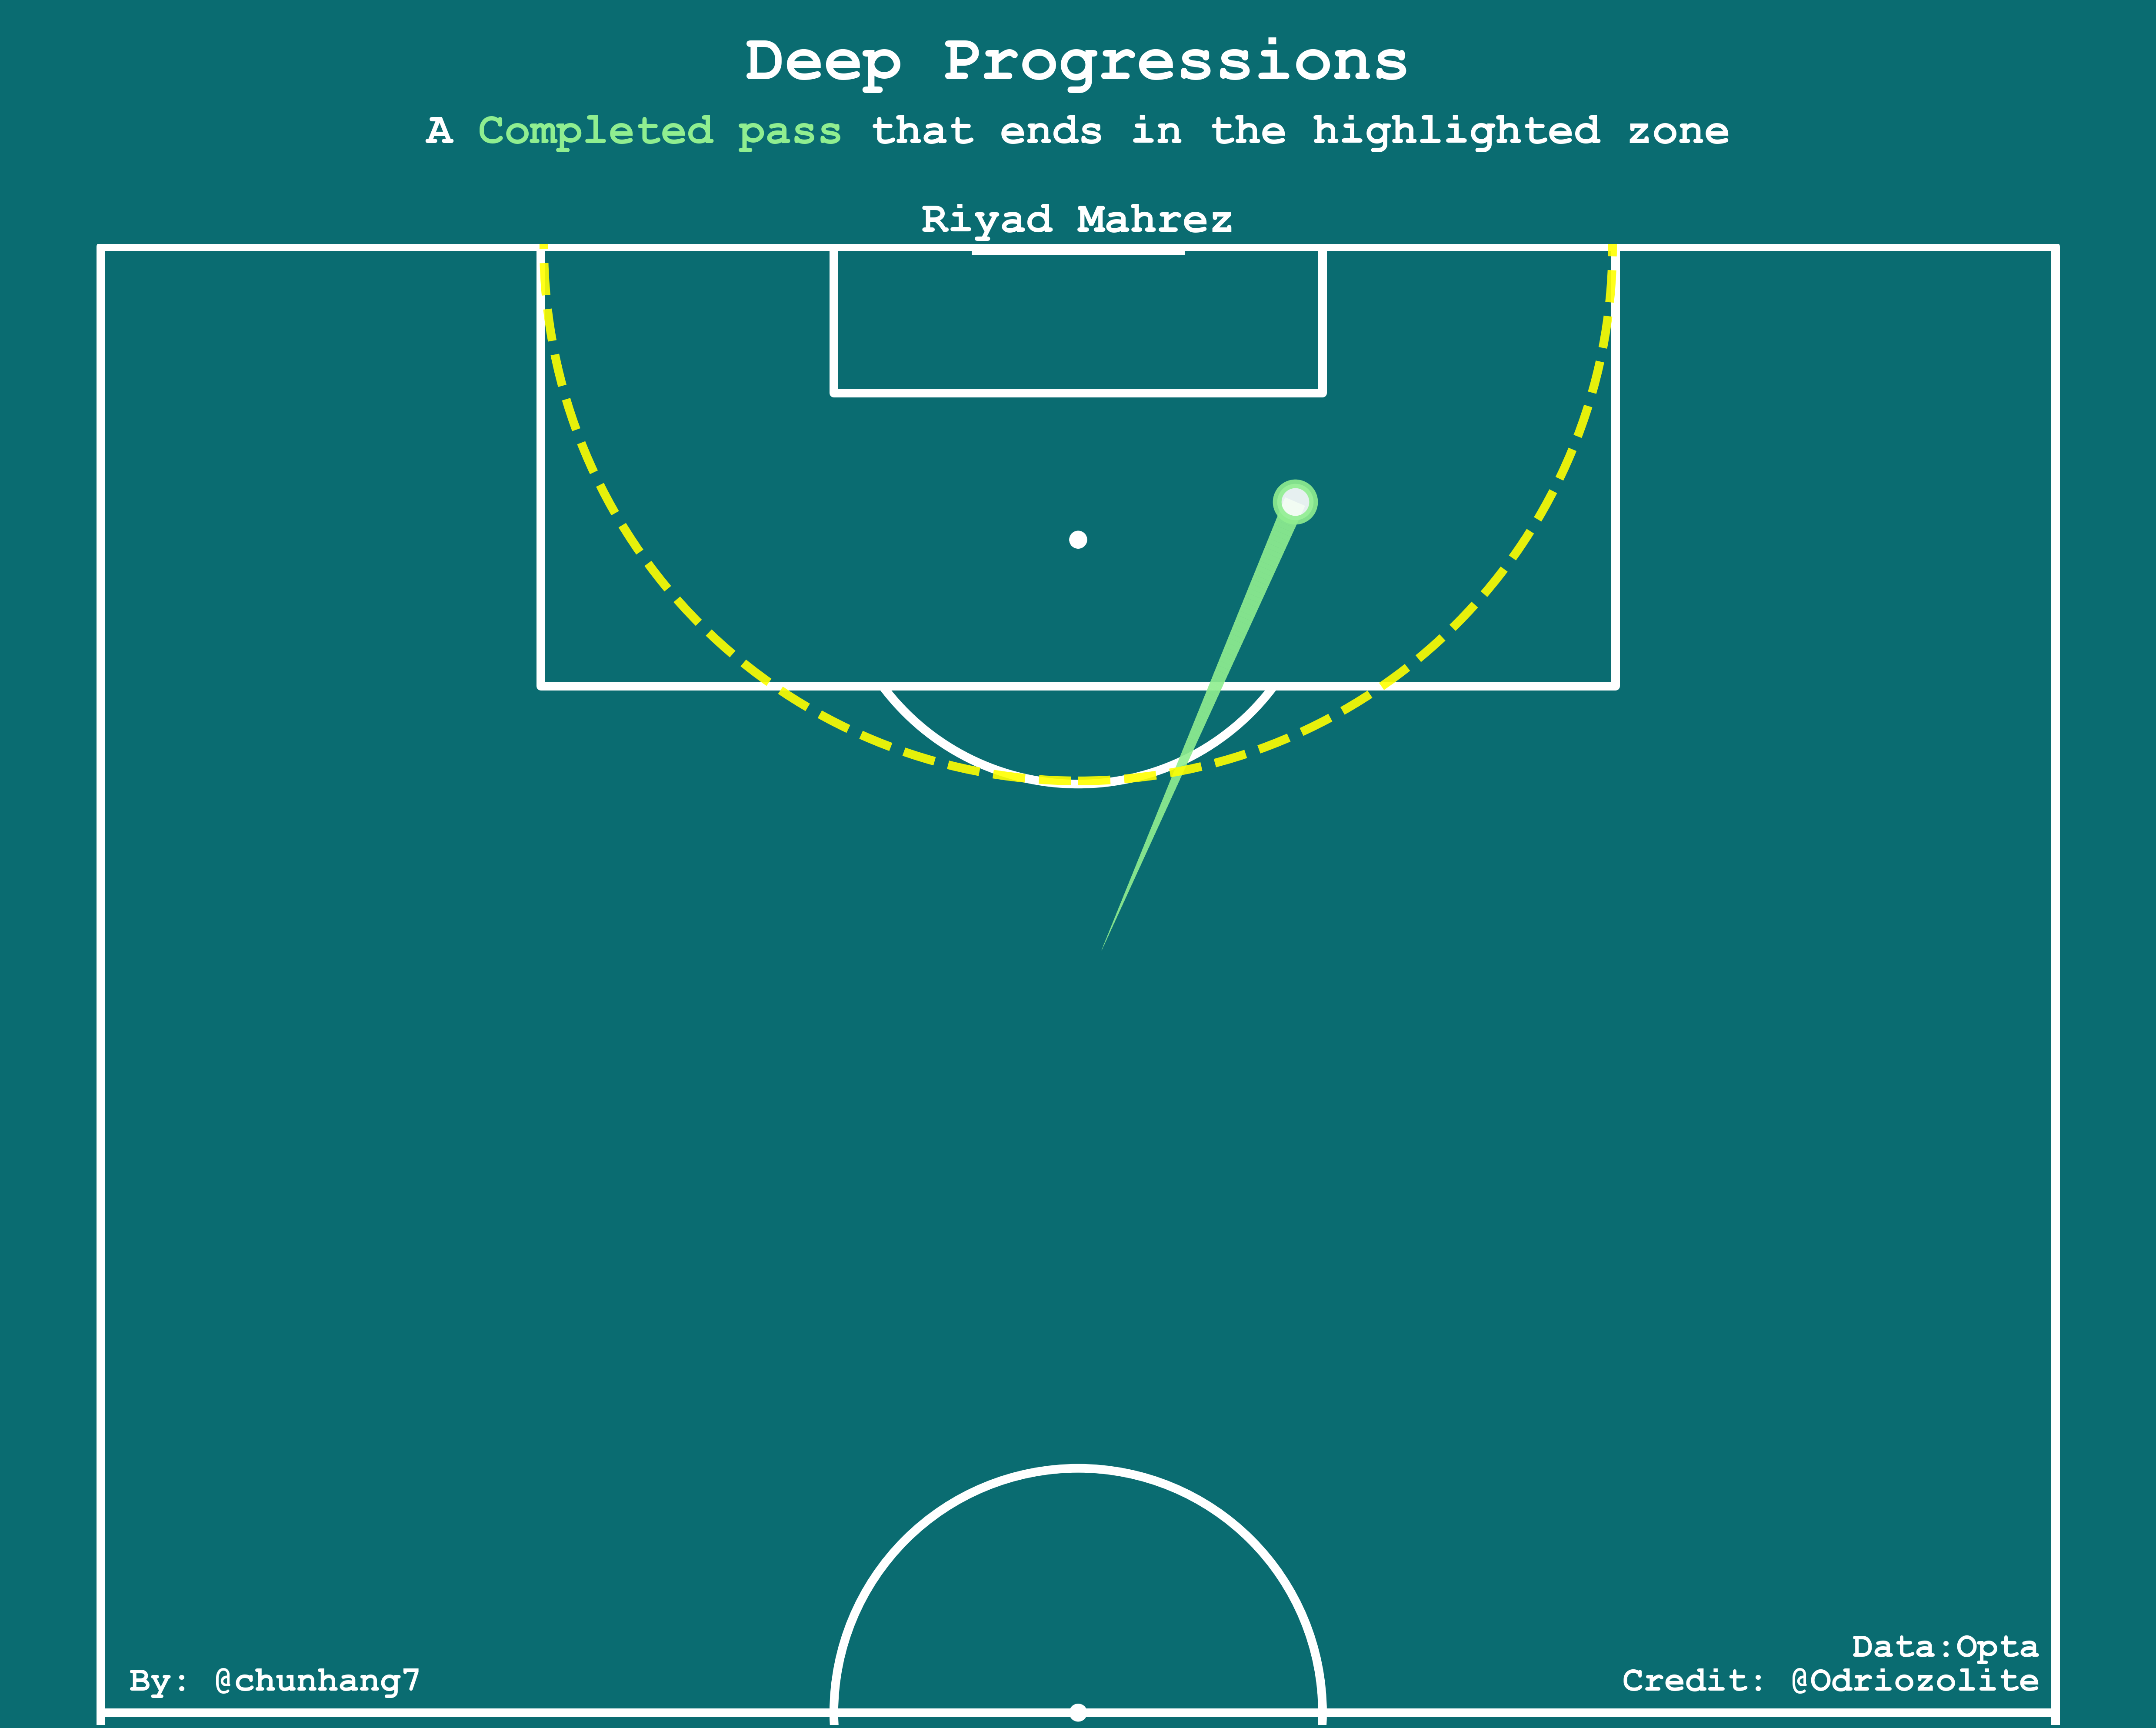

In [9]:
#Plotting the pitch

pitch = VerticalPitch(pitch_type='statsbomb', figsize = (13,9),pad_top=0.1, pad_bottom=0.5,
                  pitch_color="#0a6c71", line_color="white",half = True,
                  constrained_layout=False, tight_layout=True, line_zorder=1, linewidth=20, spot_scale=0.003)

fig, ax = pitch.grid(nrows=1, ncols=1, figheight=55,
                     endnote_height=0.0, endnote_space=0, axis=False,
                     title_height=0.13, grid_height=0.86, space=0.11)

fig.set_facecolor("#0a6c71")


#Title & Annotations
fig.suptitle("Deep Progressions", fontsize=150, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.98)


highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}]

Title = fig_text(s = "A <Completed pass> that ends in the highlighted zone" ,
        x = 0.5, y = 0.935, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=100);

#Draw Half Circle on Pitch
circle = patches.Circle([40,120],radius = 21.87 , linewidth = 20, linestyle='--',
                  edgecolor='yellow', facecolor='none', alpha=0.9, zorder=3 )

ax['pitch'].add_patch(circle)

#Defining out plotting function
def plot_DC(df, player):
    df = df[(df['playername'] == player)]
    
    ax['pitch'].set_title(str(player), fontsize=100, color="white",
                  fontfamily = "Courier New", fontweight = 'bold', va="center", ha="center", pad=50)
    
    pitch.lines(df['x'], 80-df['y'], df['endX'], 80-df['endY'], 
                ax=ax['pitch'],comet = True, color= "lightgreen", lw=50, alpha = 0.7)
    
    pitch.scatter(df['endX'], 80-df['endY'], edgecolors= "lightgreen", c="w",
          s = 7000, zorder=4, ax=ax['pitch'], marker = 'o', alpha = 0.9,linewidths=20)
    

plot_DC(df = deepcompletionpass, player=player)

#credits
fig.text(.925,.02,'Data:Opta\nCredit: @Odriozolite',fontsize=80,fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')

fig.text(.21,.02,'By: @chunhang7',fontsize=80, fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')
plt.show()

In [ ]:
#Plotting the pitch

pitch = VerticalPitch(pitch_type='statsbomb', figsize = (13,9),pad_top=0.1, pad_bottom=0.5,
                  pitch_color="#0a6c71", line_color="white",half = True,
                  constrained_layout=True, tight_layout=True, line_zorder=1, linewidth=20, spot_scale=0.003)

fig, ax = pitch.grid(nrows=1, ncols=1, figheight=55,
                     endnote_height=0.0, endnote_space=0, axis=False,
                     title_height=0.13, grid_height=0.86, space=0.11)

fig.set_facecolor("#0a6c71")

#Title & Annotations
fig.suptitle("Deep Progressions", fontsize=150, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.98)


highlight_textprops =\
    [{"color": "#fd5901","fontweight": 'bold'}]

Title = fig_text(s = "A <Carry> that ends in the highlighted zone" ,
        x = 0.5, y = 0.935, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=100);

#Draw Half Circle on Pitch
circle = patches.Circle([40,120],radius = 21.87 , linewidth = 20, linestyle='--',
                  edgecolor='yellow', facecolor='none', alpha=0.9, zorder=3 )
ax['pitch'].add_patch(circle)


#Defining out plotting function
def plot_DC(df, player):
    df = df[(df['Recipient'] == player)]
    
    ax['pitch'].set_title(str(player), fontsize=100, color="white",
                  fontfamily = "Courier New", fontweight = 'bold', va="center", ha="center", pad=50)
    
    pitch.lines(df['endX'], 80-df['endY'], df['x_next'], 80-df['y_next'], 
                ax=ax['pitch'],comet = True, color= "#fd5901", lw=50, alpha = 0.7)
    
    pitch.scatter(df['x_next'], 80-df['y_next'], edgecolors= "#fd5901", c="w",
          s = 7000, zorder=4, ax=ax['pitch'], marker = 'o', alpha = 0.9,linewidths=20)
    
plot_DC(df = deepcompletioncarries, player=player)

#credits
fig.text(.925,.02,'Data:Opta\nCredit: @Odriozolite',fontsize=80,fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')

fig.text(.21,.02,'By: @chunhang7',fontsize=80, fontfamily='Courier New',
       ha='right',color='w',fontweight='bold')
plt.show()